In [3]:
import pandas as pd
import numpy as np
import duckdb

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [4]:
# Caminho do banco
db_path = "../../../data/duckdb/database.duckdb"

# Conexão com o banco DuckDB
con = duckdb.connect(db_path)

# Carrega os dados da camada bronze
df = con.execute("SELECT * FROM gold.consumo_geral").df()

# Feature Engineering

In [5]:
# Agrupa por cliente e extrai features relevantes
input_df = df.groupby('client_id').agg({
    'consumption_kwh': ['mean'],
    'temperature': 'mean',
    'humidity': 'mean',
    'region': 'first'
}).reset_index()

input_df.columns = ['client_id', 'mean_consumption', 'mean_temperature', 'mean_humidity', 'region']

input_df.head()

,client_id,mean_consumption,mean_temperature,mean_humidity,region
0,C0000,16.252611,24.993203,60.174688,Norte
1,C0001,18.926167,24.993203,60.174688,Norte
2,C0002,18.624611,25.067315,59.734148,Sul
3,C0003,15.284000,24.993203,60.174688,Norte
4,C0004,14.446500,25.179830,60.064383,Oeste


In [6]:
# One-hot encoding da coluna de região (sem prefixo)
input_df = pd.get_dummies(input_df, columns=['region'], prefix='', prefix_sep='')

In [7]:
# Normaliza os dados (exceto client_id)
features = input_df.drop(columns=['client_id'])
scaler = StandardScaler()
input_df = scaler.fit_transform(features)

# Treinamento de Modelo

In [8]:
def metodo_cotovelo(X: np.ndarray, k_inicio=2, k_fim=10):
    """
    Aplica KMeans para diferentes valores de K em uma matriz numpy e plota
    o método do cotovelo e o silhouette score.

    Parâmetros:
    - X: array numpy de shape (n_amostras, n_features), já escalado.
    - k_inicio: valor inicial de K para o método do cotovelo.
    - k_fim: valor final de K (inclusive).
    """
    inertia = []
    silhouette_scores = []

    for k in range(k_inicio, k_fim + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, labels))

    # Plot com dois eixos Y
    fig, ax1 = plt.subplots()

    color_inertia = 'tab:blue'
    color_silhouette = 'tab:green'

    ax1.set_xlabel('Número de Clusters (K)')
    ax1.set_ylabel('Inertia', color=color_inertia)
    ax1.plot(range(k_inicio, k_fim + 1), inertia, 'o-', color=color_inertia, label='Inertia')
    ax1.tick_params(axis='y', labelcolor=color_inertia)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Silhouette Score', color=color_silhouette)
    ax2.plot(range(k_inicio, k_fim + 1), silhouette_scores, 's--', color=color_silhouette, label='Silhouette Score')
    ax2.tick_params(axis='y', labelcolor=color_silhouette)

    fig.tight_layout()
    plt.title('KMeans: Inertia e Silhouette Score')
    plt.grid(True)
    plt.show()

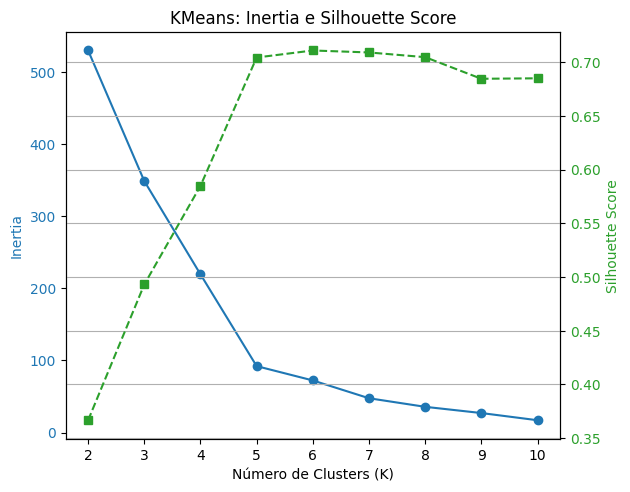

In [9]:
metodo_cotovelo(input_df, k_inicio=2, k_fim=10)

# À medida que você aumenta o número de clusters 𝐾, o modelo se ajusta melhor aos dados, 
# e a soma das distâncias intra-cluster (também chamada de inertia ou WCSS – Within-Cluster Sum of Squares) diminui.
# Após certo ponto, o ganho na redução da distância é cada vez menor. Esse ponto de desaceleração forma o “cotovelo” no gráfico.

# Baseado no método do cotovelo, escolhemos K=5 

In [10]:
# Grid de parâmetros
param_grid = {
    'eps': [0.3, 0.5, 0.7, 1.0],
    'min_samples': [3, 5, 10]
}

# Avalia DBSCAN para cada combinação
dbscan_results = []
for params in ParameterGrid(param_grid):
    db = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    labels = db.fit_predict(input_df)

    # Só avalia se mais de um cluster foi encontrado
    if len(set(labels)) > 1 and len(set(labels)) < len(input_df):
        score = silhouette_score(input_df, labels)
        dbscan_results.append({
            'eps': params['eps'],
            'min_samples': params['min_samples'],
            'silhouette': score,
            'n_clusters': len(set(labels)) - (1 if -1 in labels else 0)  # Exclui o ruído (-1)
        })

# Resultados ordenados
df_dbscan = pd.DataFrame(dbscan_results)
df_dbscan = df_dbscan.sort_values(by='silhouette', ascending=False)

print("\nTop 5 resultados DBSCAN (por silhouette):")
print(df_dbscan.head())



Top 5 resultados DBSCAN (por silhouette):
   eps  min_samples  silhouette  n_clusters
2  0.5            3    0.723878           9
6  0.7            5    0.710700           7
5  0.7            3    0.710447           6
9  1.0            5    0.704260           5
8  1.0            3    0.704260           5


0.7042597624214859


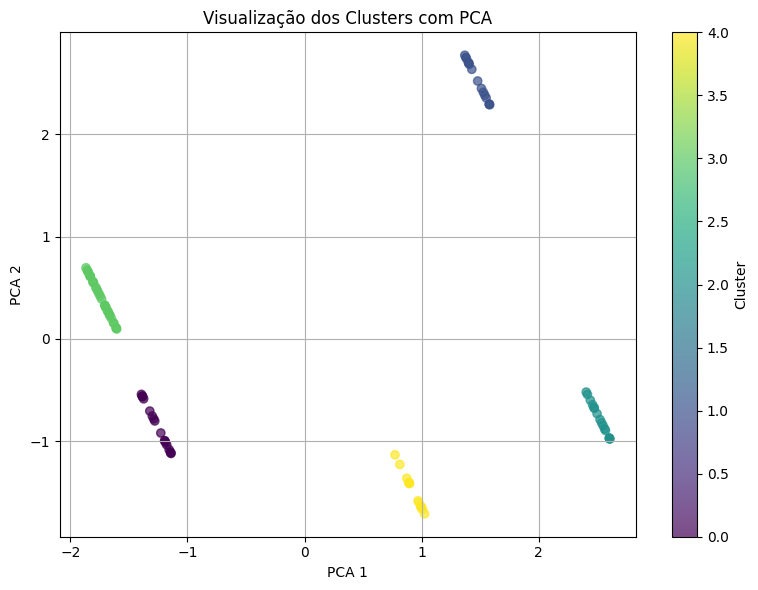

In [11]:
# Treinamento do modelo KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(input_df)
labels = kmeans.labels_

print(silhouette_score(input_df, labels))

# Aplicando PCA para redução de dimensionalidade
pca = PCA(n_components=2)
pca_result = pca.fit_transform(input_df)

# Visualização
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    c=labels,
    cmap='viridis',
    alpha=0.7
)
plt.title('Visualização dos Clusters com PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


0.7238775374851867


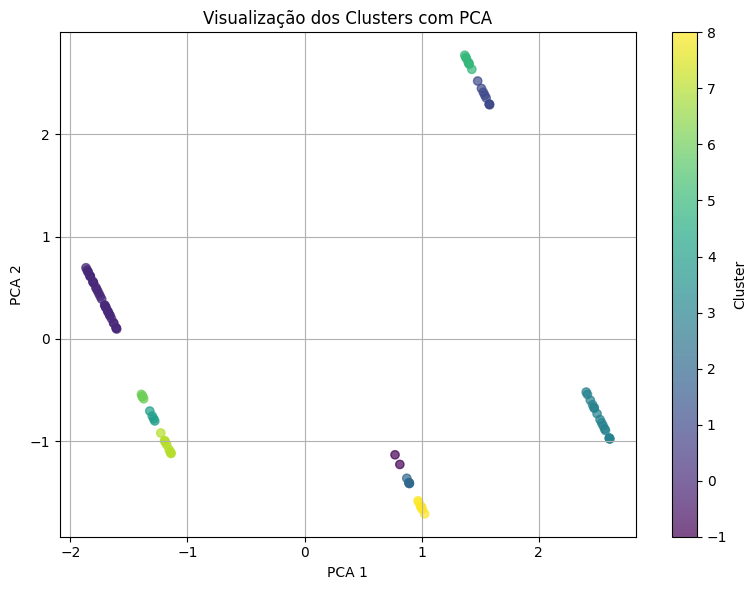

In [12]:
# Treinamento do modelo KMeans
dbscan = DBSCAN(eps=0.5, min_samples=3)
labels = dbscan.fit_predict(input_df)

# Aplicando PCA para redução de dimensionalidade
pca = PCA(n_components=2)
pca_result = pca.fit_transform(input_df)

print(silhouette_score(input_df, labels))

# Visualização
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    c=labels,
    cmap='viridis',
    alpha=0.7
)
plt.title('Visualização dos Clusters com PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
# Após análise gráfico foi possível observar que o KMeans conseguiu realizar uma boa separação dos clusters, 
# já o DBSCAN não conseguiu separar bem os clusters, pois há vários pontos classificados como ruídos e alguns pontos estão próximos entre dois cluster não tão bem definidos.